# Intrusion Detection System using Adversarial Machine Learning (AML) 
As many network services and functionalities rely on AI/ML models, they are becoming increasingly vulnerable to AML attacks. AML attacks exploit the weaknesses and vulnerabilities of ML models by generating adversarial inputs that can deceive or manipulate the models into making incorrect predictions. In networks, AML attacks pose a significant threat to overall network security and reliability.  
This case study aims to demonstrate the detrimental impact that AML attacks can have on ML models in networks and presents basic defense strategies to mitigate these attacks, thereby ensuring the accuracy of the ML-based IDS. In this case study, three common types of adversarial attacks ((i.e., DTA, FGSM, and BIM)) are used to generate adversarial samples to probe the vulnerability of the IDS.  
Subsequently, basic defense mechanisms, including adversarial sample detection and filtering, are devised to safeguard the AutoML-based IDS against AML attacks.  

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
from imblearn.over_sampling import SMOTE
import time

In [2]:
import warnings 
warnings.filterwarnings('ignore')

## Read the sampled CICIDS2017 dataset

In [3]:
dataset = pd.read_csv("C:/Users/parik/Downloads/AutoML-and-Adversarial-Attack-Defense-for-Zero-Touch-Network-Security/Data/cicids.csv")

In [4]:
dataset

,Flow Duration,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Flow IAT Mean,Flow IAT Min,Fwd IAT Min,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Label
0,50833,0,0,0.0000,0,0,5.083300e+04,50833,0,32,32,19.672260,19.672260,0,1,1,319,153,32,0
1,49,0,0,0.0000,0,0,4.900000e+01,49,49,64,0,40816.326530,0.000000,0,0,0,277,-1,32,0
2,306,6,6,6.0000,6,6,3.060000e+02,306,0,20,20,3267.973856,3267.973856,6,0,1,0,0,20,0
3,63041,65,65,65.0000,124,124,6.304100e+04,63041,0,32,32,15.862693,15.862693,65,0,1,-1,-1,32,0
4,47682,43,43,43.0000,59,59,4.768200e+04,47682,0,32,32,20.972275,20.972275,43,0,1,-1,-1,32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28298,45,0,0,0.0000,0,0,4.500000e+01,45,0,32,32,22222.222220,22222.222220,0,1,1,349,307,32,0
28299,114309573,511,427,31.9375,746,0,3.941709e+06,94,165,332,424,0.139971,0.122474,0,0,0,8192,343,20,0
28300,48850,80,40,40.0000,72,72,1.628333e+04,1,48,64,64,40.941658,40.941658,40,0,1,-1,-1,32,0
28301,260,66,33,33.0000,97,97,8.666667e+01,48,48,40,40,7692.307692,7692.307692,33,0,1,-1,-1,20,0


# Automated Data Pre-Processing

## Automated Transformation/Encoding
Automatically identify and transform string/text features into numerical features to make the data more readable by ML models

In [5]:

def convert_categorical_to_numerical(data_frame):
    # Identify columns with object data type (categorical features)
    categorical_columns = [col for col in data_frame.columns if data_frame[col].dtype == "object"]

    # Create an instance of LabelEncoder
    label_encoder = LabelEncoder()

    # Iterate over categorical columns and encode them numerically
    for column in categorical_columns:
        if column in data_frame.columns:
            # Convert the column values to strings and then encode them
            data_frame[column] = label_encoder.fit_transform(data_frame[column].astype(str))

    return data_frame


In [6]:
dataset=convert_categorical_to_numerical(dataset)

## Automated Imputation
Detect and impute missing values to improve data quality

In [7]:
def impute_missing_values(data_frame):
    # Check if the DataFrame contains any missing or infinite values
    if data_frame.isnull().values.any() or np.isinf(data_frame).values.any():
        # Replace positive and negative infinite values with NaN
        data_frame.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Fill all NaN values with zeros
        data_frame.fillna(0, inplace=True)
    
    return data_frame


In [8]:
dataset=impute_missing_values(dataset)

## Automated normalization
Normalize the range of features to a similar scale to improve data quality

In [9]:
import pandas as pd
from scipy.stats import shapiro

def normalize_features(data_frame):
    # Perform Shapiro-Wilk test on the entire DataFrame
    stat, p_value = shapiro(data_frame.select_dtypes(include=[np.number]))
    print(f'Statistics={stat:.3f}, p={p_value:.3f}')

    alpha = 0.05
    numerical_cols = data_frame.drop(['Label'], axis=1).dtypes[data_frame.dtypes != 'object'].index

    # Choose normalization method based on Shapiro-Wilk test result
    if p_value > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
        normalization_method = 'Z-score'
        # Apply Z-score normalization
        data_frame[numerical_cols] = data_frame[numerical_cols].apply(lambda x: (x - x.mean()) / x.std())
    else:
        print('Sample does not look Gaussian (reject H0)')
        normalization_method = 'Min-Max'
        # Apply Min-Max normalization
        data_frame[numerical_cols] = data_frame[numerical_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    print(f'{normalization_method} normalization is automatically chosen and used')
    return data_frame


In [10]:
dataset=normalize_features(dataset)

Statistics=0.076, p=0.000
Sample does not look Gaussian (reject H0)
Min-Max normalization is automatically chosen and used


In [11]:
dataset=impute_missing_values(dataset)

## Train-test split
Split the dataset into the training and the test set

In [12]:
X = dataset.drop(['Label'],axis=1)
y = dataset['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2,random_state = 0)

## Automated data balancing
Generate minority class samples to solve class-imbalance and improve data quality.  
Synthetic Minority Over-sampling Technique (SMOTE) method is used.

In [13]:
pd.Series(y_train).value_counts()

Label
0    18126
1     4516
Name: count, dtype: int64

In [14]:
import pandas as pd
from imblearn.over_sampling import SMOTE

def balance_binary_dataset(X_train, y_train, threshold=0.5):
    # Get the class counts
    class_counts = y_train.value_counts()

    # Determine the minority and majority class counts
    minority_count = min(class_counts)
    majority_count = max(class_counts)

    # Calculate the minority-to-majority ratio
    minority_to_majority_ratio = minority_count / majority_count

    # Check if the dataset is imbalanced based on the specified threshold
    if minority_to_majority_ratio < threshold:
        print(f"Dataset is imbalanced. Minority-to-majority ratio: {minority_to_majority_ratio:.2f}")

        # Determine the desired sample size for both classes
        target_sample_size = max(class_counts)

        # Apply SMOTE oversampling to balance the classes
        smote = SMOTE(sampling_strategy={0: target_sample_size, 1: target_sample_size}, n_jobs=-1)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

        print("Dataset balanced using SMOTE oversampling.")
        return X_train_balanced, y_train_balanced
    else:
        print("Dataset is balanced. No oversampling required.")
        return X_train, y_train

# Example usage
# X_train and y_train are your training features and labels
X_train_balanced, y_train_balanced = balance_binary_dataset(X_train, y_train)

Dataset is imbalanced. Minority-to-majority ratio: 0.25
Dataset balanced using SMOTE oversampling.


In [15]:
pd.Series(y_train).value_counts()

Label
0    18126
1     4516
Name: count, dtype: int64

# Automated Feature Engineering
Feature selection method 1: **Information Gain (IG)**, used to remove irrelevant features to improve model efficiency  
Feature selection method 2: **Pearson Correlation**, used to remove redundant features to improve model efficiency and accuracy  

In [16]:
import pandas as pd
import numpy as np
import lightgbm as lgb

def identify_low_importance_features(data, target_column, cumulative_importance_threshold=0.9):
    features = data.drop(target_column, axis=1).values
    labels = data[target_column].values
    feature_names = list(data.drop(target_column, axis=1).columns)

    model = lgb.LGBMRegressor(verbose=-1)
    model.fit(features, labels)

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

    low_importance_features = feature_importances[feature_importances['cumulative_importance'] > cumulative_importance_threshold]['feature'].tolist()

    return low_importance_features

def remove_redundant_features(data, target_column, correlation_threshold=0.9):
    features = data.drop(target_column, axis=1)
    corr_matrix = features.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    redundant_features = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > correlation_threshold)]

    return redundant_features

def perform_feature_engineering(data, target_column, cumulative_importance_threshold=0.9, correlation_threshold=0.9):
    low_importance_features = identify_low_importance_features(data, target_column, cumulative_importance_threshold)
    data_without_low_importance = data.drop(columns=low_importance_features)

    redundant_features = remove_redundant_features(data_without_low_importance, target_column, correlation_threshold)
    data_without_redundant = data_without_low_importance.drop(columns=redundant_features)

    return data_without_redundant

# Example usage
# Assuming 'dataset' is your input DataFrame and 'Label' is the target column
modified_dataset = perform_feature_engineering(dataset, 'Label')
modified_dataset

,Flow Duration,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Flow IAT Mean,Flow IAT Min,Fwd IAT Min,Fwd Header Length,Bwd Packets/s,Init_Win_bytes_forward,Init_Win_bytes_backward,Label
0,4.236419e-04,0.000000,0.000000,0.000000,0.000000,4.707129e-04,4.707129e-04,0.000000e+00,0.000150,1.311484e-05,0.004883,0.002350,0
1,4.416669e-07,0.000000,0.000000,0.000000,0.000000,4.907407e-07,4.907407e-07,4.083333e-07,0.000299,0.000000e+00,0.004242,0.000000,0
2,2.583334e-06,0.000008,0.000242,0.001556,0.000516,2.870370e-06,2.870370e-06,0.000000e+00,0.000094,2.178649e-03,0.000015,0.000015,0
3,5.253752e-04,0.000090,0.002619,0.016856,0.010660,5.837500e-04,5.837500e-04,0.000000e+00,0.000150,1.057513e-05,0.000000,0.000000,0
4,3.973835e-04,0.000060,0.001732,0.011151,0.005072,4.415370e-04,4.415370e-04,0.000000e+00,0.000150,1.398152e-05,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28298,4.083335e-07,0.000000,0.000000,0.000000,0.000000,4.537037e-07,4.537037e-07,0.000000e+00,0.000150,1.481481e-02,0.005341,0.004700,0
28299,9.525802e-01,0.000710,0.017204,0.008282,0.064133,3.649735e-02,9.074074e-07,1.375000e-06,0.001554,8.164962e-08,0.125015,0.005249,0
28300,4.071168e-04,0.000111,0.001612,0.010373,0.006190,1.508086e-04,4.629629e-08,4.000000e-07,0.000299,2.729444e-05,0.000000,0.000000,0
28301,2.200001e-06,0.000092,0.001330,0.008558,0.008339,8.395061e-07,4.814815e-07,4.000000e-07,0.000187,5.128205e-03,0.000000,0.000000,0


## Data Split & Balancing (After Feature Engineering)

In [17]:
X = modified_dataset.drop(['Label'],axis=1)
y = modified_dataset['Label']

#X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, shuffle=False,random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2,random_state = 0)

In [18]:
X_train, y_train = balance_binary_dataset(X_train, y_train)

Dataset is imbalanced. Minority-to-majority ratio: 0.25
Dataset balanced using SMOTE oversampling.


# Automated Model Selection
Select the best-performing model among five common machine learning models (Naive Bayes, KNN, random forest, LightGBM, and ANN/MLP) by evaluating their learning performance

## Model learning (for Comparison)

In [19]:
%%time
lg = lgb.LGBMClassifier(verbose = -1)
lg.fit(X_train,y_train)
t1=time.time()
lg_predict = lg.predict(X_test)
t2=time.time()
print("Accuracy: "+str(round(accuracy_score(y_test,lg_predict),5)*100)+"%")


Accuracy: 99.77000000000001%
CPU times: total: 2.17 s
Wall time: 231 ms


In [20]:
%%time
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
t1=time.time()
rfc_predict = rf.predict(X_test)
t2=time.time()
print("Accuracy: "+str(round(accuracy_score(y_test,rfc_predict),5)*100)+"%")


Accuracy: 99.753%
CPU times: total: 844 ms
Wall time: 3.43 s


### As we can see LGBM Classifier gives better accuracy as compared to RandomForestClassifier. So we will select LGBMClassifier.

# AML

### Basic Steps
* 1. Original ML model for IDS
* 2. Generate adversarial samples using DecisionTreeAttack or other attacks
* 3. Test ML model under attack
* 4. Develop adversarial sample detection model
* 5. Remove adversarial samples from the training set
* 6. Re-train IDS model

## DecisionTreeAttack

### Step 1: Original ML model for IDS

In [21]:
%%time
classifier = lgb.LGBMClassifier(max_depth=22, learning_rate= 0.06157312210088248, n_estimators = 360, 
                         num_leaves = 2000, min_child_samples = 20)
classifier.fit(X_train,y_train)
lg_predict = classifier.predict(X_test)
print("Accuracy: "+str(round(accuracy_score(y_test,lg_predict),5)*100)+"%")
Accuracy_1=accuracy_score(y_test,lg_predict)*100


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18126, number of negative: 18126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3058
[LightGBM] [Info] Number of data points in the train set: 36252, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

### Step 2: generate adversarial samples using DecisionTreeAttack

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
import numpy as np

from art.attacks.evasion import DecisionTreeAttack
from art.estimators.classification import SklearnClassifier

classifier = DecisionTreeClassifier()
classifier.fit(X_train,y_train)
from sklearn.preprocessing import OneHotEncoder
y_train1 = y_train.values.reshape(-1, 1)
y_train1_AML = OneHotEncoder().fit_transform(y_train1).toarray()

classifier_art = SklearnClassifier(classifier)
attack = DecisionTreeAttack(classifier_art)

# Generate adversarial examples
x_adv = attack.generate(X_train.values,y_train1_AML)

Decision tree attack: 100%|██████████| 36252/36252 [00:13<00:00, 2748.36it/s]


### Step 3: Test ML model under attack

In [23]:
%%time
#DTA
temp = lgb.LGBMClassifier(max_depth=22, learning_rate= 0.06157312210088248, n_estimators = 360, 
                         num_leaves = 2000, min_child_samples = 20)
temp.fit(x_adv,y_train)
t1=time.time()
lg_predict = temp.predict(X_test)
t2=time.time()
print("Accuracy: "+str(round(accuracy_score(y_test,lg_predict),5)*100)+"%")

Accuracy_2=accuracy_score(y_test,lg_predict)*100


[LightGBM] [Info] Number of positive: 18126, number of negative: 18126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2577
[LightGBM] [Info] Number of data points in the train set: 36252, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

### Step 4: Develop adversarial sample detection model


In [24]:
X_new = np.concatenate([x_adv,X_train])
y1 = pd.Series(np.ones(y_train.shape[0]))
y2 = pd.Series(np.zeros(y_train.shape[0]))
y_new = np.concatenate([y1,y2])


X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(X_new,y_new, train_size = 0.1, test_size = 0.9,random_state = 0)

In [25]:
%%time
temp = lgb.LGBMClassifier(max_depth=22, learning_rate= 0.06157312210088248, n_estimators = 360, 
                         num_leaves = 2000, min_child_samples = 20)
temp.fit(X_train_det,y_train_det)
t1=time.time()
lg_predict2 = temp.predict(X_test_det)
t2=time.time()
print("Accuracy: "+str(round(accuracy_score(y_test_det,lg_predict2),5)*100)+"%")


[LightGBM] [Info] Number of positive: 3671, number of negative: 3579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2968
[LightGBM] [Info] Number of data points in the train set: 7250, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506345 -> initscore=0.025381
[LightGBM] [Info] Start training from score 0.025381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

### Step 5: Remove adversarial samples from the training set

In [26]:
detection_results = temp.predict(X_new)
X_new1 = X_new
y_new1 = np.concatenate([y_train,y_train])

indices_to_remove = [i for i in range(len(detection_results)) if detection_results[i] == 1]
for i in reversed(indices_to_remove):
    X_new1 = np.delete(X_new1, i, axis=0)
    y_new1 = np.delete(y_new1, i)

### Step 6: Re-train IDS model

In [27]:
%%time
#DTA
temp = lgb.LGBMClassifier(max_depth=22, learning_rate= 0.06157312210088248, n_estimators = 360, 
                         num_leaves = 2000, min_child_samples = 20)
temp.fit(X_new1,y_new1)
t1=time.time()
lg_predict = temp.predict(X_test)
t2=time.time()
print("Accuracy: "+str(round(accuracy_score(y_test,lg_predict),5)*100)+"%")

Accuracy_3=accuracy_score(y_test,lg_predict)*100


[LightGBM] [Info] Number of positive: 18126, number of negative: 18112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3058
[LightGBM] [Info] Number of data points in the train set: 36238, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500193 -> initscore=0.000773
[LightGBM] [Info] Start training from score 0.000773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

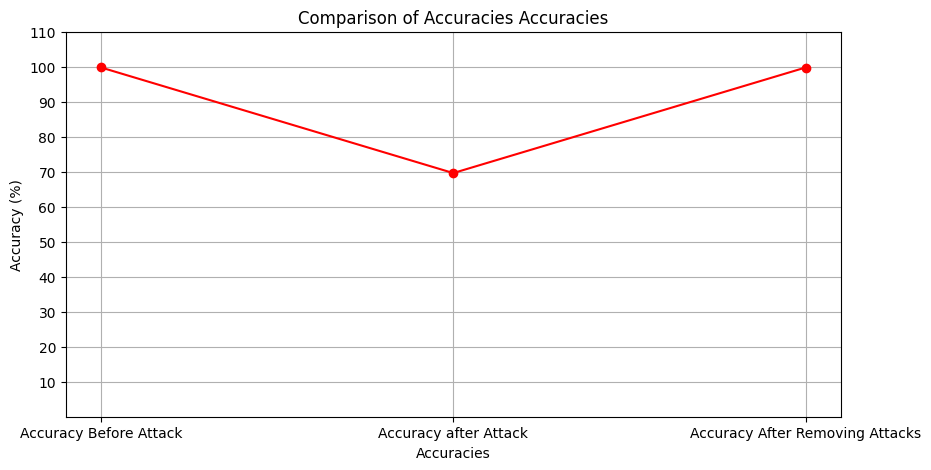

In [28]:
accuracies = [Accuracy_1, Accuracy_2, Accuracy_3]
labels = ['Accuracy Before Attack', 'Accuracy after Attack', 'Accuracy After Removing Attacks']

plt.figure(figsize=(10, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-', color='r')
plt.title('Comparison of Accuracies Accuracies')
plt.xlabel('Accuracies')
plt.ylabel('Accuracy (%)')
plt.yticks([10, 20, 30, 40,50,60,70,80,90,100,110])
plt.ylim(0, 110) 
plt.grid(True)
plt.show()


# Model Stealing

In this method, the attacker tries to create a surrogate model based on queries to the original model

### Creating the Target Model

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Train the target model
target_model = DecisionTreeClassifier(max_depth=5)
target_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5)

### Generating Queries

In [30]:
queries = X_test
true_outputs = target_model.predict(queries)


### Training the Substitute Model

In [31]:
substitute_model = DecisionTreeClassifier(max_depth=5)
substitute_model.fit(queries, true_outputs)


DecisionTreeClassifier(max_depth=5)

### Evaluating the Substitute

In [32]:
from sklearn.metrics import accuracy_score

# Predict using the substitute model
substitute_predictions = substitute_model.predict(X_test)

# Evaluate the accuracy of the substitute model
accuracy = accuracy_score(y_test, substitute_predictions)
print("Accuracy of the substitute model: {:.2f}%".format(accuracy * 100))


Accuracy of the substitute model: 91.08%


# Poisoning Attacks

### Implementing a Label Flipping Attack

Poisoning attacks are a type of adversarial threat where an attacker deliberately manipulates the training data of a machine learning model. The goal is to compromise the model's integrity, causing it to make incorrect predictions or decisions, which can be especially harmful in security-sensitive applications.

In [33]:
# Train a decision tree classifier on the clean dataset
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)
baseline_accuracy = accuracy_score(y_test, classifier.predict(X_test))
print(f"Baseline Accuracy: {baseline_accuracy * 100:.2f}%")


Baseline Accuracy: 99.61%


In [34]:
# Flip the labels of 10% of the training dataset
np.random.seed(42)
indices_to_flip = np.random.choice(len(y_train), size=int(0.1 * len(y_train)), replace=False)
y_train_poisoned = np.copy(y_train)
y_train_poisoned[indices_to_flip] = 1 - y_train[indices_to_flip]

# Retrain the classifier on the poisoned dataset
clf_poisoned = DecisionTreeClassifier(random_state=42)
clf_poisoned.fit(X_train, y_train_poisoned)
poisoned_accuracy = accuracy_score(y_test, clf_poisoned.predict(X_test))
print(f"Poisoned Accuracy: {poisoned_accuracy * 100:.2f}%")


Poisoned Accuracy: 90.64%


# Extraction attacks

 Extraction attacks,aim to reverse-engineer the model to either obtain sensitive information that was used to train the model or to replicate the model’s functionality without authorization.

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np


# Train the target model
target_model = DecisionTreeClassifier(max_depth=5)
target_model.fit(X_train, y_train)

# Assume the attacker can only use the predict function
def query_target_model(data):
    return target_model.predict(data)

# The attacker generates a new set of data to query the target model
attacker_data = np.random.rand(500, 12)  # Assume we know the input shape
attacker_labels = query_target_model(attacker_data)

# The attacker trains a substitute model
substitute_model = DecisionTreeClassifier(max_depth=5)
substitute_model.fit(attacker_data, attacker_labels)


# Assessing how close the substitute model is to the original model
original_predictions = target_model.predict(X_test)
substitute_predictions = substitute_model.predict(X_test)

# Calculate the accuracy of the substitute model on the original test data
substitute_accuracy = accuracy_score(y_test, substitute_predictions)
original_accuracy = accuracy_score(y_test, original_predictions)



print(f"Original Model Accuracy: {original_accuracy*100:.2f}%")
print(f"Substitute Model Accuracy: {substitute_accuracy*100:.2f}%")


Original Model Accuracy: 90.92%
Substitute Model Accuracy: 79.42%
